In [1]:
### import des dependences ###
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import xgboost as xgb
import pickle
import datetime

### chargement des fichiers d'entrainement ###

trainfile = datetime.datetime.now().strftime("%Y-%m-")
day = int(datetime.datetime.now().strftime("%d"))
day = str(day - 1)
trainfile = trainfile + day
r16_tab1 = pd.read_json(f'R16_tab1_{trainfile}.log', lines=True)


# for weekdata
# df16 = pd.read_excel('C:\\Users\\user\\deep_learning\\MDMS\\DataCompters\\R16\\R16_Tab1_2022-11-15_19\\r16_tab1_16.xlsx')
# df17 = pd.read_excel('C:\\Users\\user\\deep_learning\\MDMS\\DataCompters\\R16\\R16_Tab1_2022-11-15_19\\r16_tab1_17.xlsx')
# df18 = pd.read_excel('C:\\Users\\user\\deep_learning\\MDMS\\DataCompters\\R16\\R16_Tab1_2022-11-15_19\\r16_tab1_18.xlsx')
# liste_concat = [df16, df17, df18]
# r16_tab1 = pd.concat(liste_concat)



r16_tab1['date'] = r16_tab1['date_heure_mesure']
r16_tab1 = r16_tab1.set_index('date')
r16_tab1.index = pd.to_datetime(r16_tab1.index)
# copie du dataframe au cas où
dataDB = r16_tab1.copy()


r16_tab1['phase'] = r16_tab1['phase'].replace(['','N'],[4, 5])
r16_tab1['phase']=r16_tab1['phase'].astype(int)

#########################  6h  ####################

r16_tab_6h = r16_tab1.loc[r16_tab1.type_mesure.isin(['max_courant', 'min_tension_n', 'max_tension_n', 
                                                 'max_tension_ph', 'min_puissance_reactive', 'max_puissance_reactive',
                                                 'max_puissance_active', 'max_puissance_apparente', 'min_courant', 'min_tension_ph',
                                                 'min_puissance_active'
                                                 ])]
# dictionnaire des données pour l'encodage
mon_dictionnaire_6h = {'max_courant': int(1), 'max_tension_n': int(2), 'max_tension_ph':int(3),  
                    'max_puissance_reactive':int(4), 'max_puissance_active':int(5), 'max_puissance_apparente':int(6), 
                    'min_courant':int(7), 'min_tension_n':int(8), 'min_tension_ph':int(9), 'min_puissance_reactive':int(10),
                    'min_puissance_active':int(11)
                    }

# création des données (feature) d'entrée
def create_features_6h(r16_tab1):
    """
    Create time series features based on time series index.
    """
    r16_tab1 = r16_tab1.copy()
    r16_tab1['heure_mesure'] = r16_tab1.index.hour
    r16_tab1['depart'] =r16_tab1.depart
    r16_tab1['type_mesure'] = r16_tab1.type_mesure
    r16_tab1['phase'] = r16_tab1.phase
    return r16_tab1


# phase d'entrainement
for type_mesure, encoder in mon_dictionnaire_6h.items():
    # print("l'élément de clé", type_mesure, "vaut", encoder)
    r16_tab1_2 = r16_tab1.copy()
    r16_tab1_2['type_mesure'] = r16_tab1_2['type_mesure'].map({
                           type_mesure : encoder,                        
                            },
                            na_action=None)

    # set(r16_tab1.phase)
    r16_tab1_2 = r16_tab1_2.dropna(subset='type_mesure')

    train = r16_tab1_2
    test = r16_tab1_2

    r16_tab1_2 = create_features_6h(r16_tab1_2)
    train = create_features_6h(train)
    test = create_features_6h(test)

    FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure']
    TARGET = 'mesure'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=10000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    # enregistrement du model entrainer        
    filename = f'r16_tab1_{type_mesure}'
    with open(f'{filename}.pkl', "wb") as f:
        pickle.dump(reg, f)

######################################  15mn  ###############################
# idem pour les données de 15mn

r16_tab_15mn = r16_tab1.loc[r16_tab1.type_mesure.isin(['energie',
                             'facteur_puissance',
                             'frequence',
                             'puissance_active',
                             'puissance_apparente',
                             'puissance_reactive',
                             'taux_de_charge',
                             'tdh_courant',
                             'tdh_tension' 
                             ])]

mon_dictionnaire_15mn = {'energie': int(12), 'facteur_puissance': int(13), 'frequence':int(14),  
                    'puissance_active':int(15), 'puissance_apparente':int(16), 'puissance_reactive':int(17), 
                    'taux_de_charge':int(18), 'tdh_courant':int(19), 'tdh_tension':int(20)                    
                    }

def create_features_15mn(r16_tab1):
            """
            Create time series features based on time series index.
            """
            r16_tab1 = r16_tab1.copy()
            r16_tab1['heure_mesure'] = r16_tab1.index.hour
            r16_tab1['minute_mesure'] = (r16_tab1.index.minute)
            r16_tab1['depart'] =r16_tab1.depart
            r16_tab1['type_mesure'] = r16_tab1.type_mesure
            r16_tab1['phase'] = r16_tab1.phase
            return r16_tab1

for type_mesure, encoder in mon_dictionnaire_15mn.items():
        # print("l'élément de clé", type_mesure, "vaut", encoder)
        r16_tab1_2 = r16_tab1.copy()

        r16_tab1_2['type_mesure'] = r16_tab1_2['type_mesure'].map({
                             type_mesure : encoder,
                            
                             },
                             na_action=None)

        # set(r16_tab1.phase)
        r16_tab1_2 = r16_tab1_2.dropna(subset='type_mesure')

        train = r16_tab1_2
        test = r16_tab1_2

        r16_tab1_2 = create_features_15mn(r16_tab1_2)
        train = create_features_15mn(train)
        test = create_features_15mn(test)

        FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure', 'minute_mesure']
        TARGET = 'mesure'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                            n_estimators=10000,
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=3,
                            learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)
                
        filename = f'r16_tab1_{type_mesure}'

        with open(f'{filename}.pkl', "wb") as f:
            pickle.dump(reg, f)

###############################  5s  ##############################
# idem pour les données de 5s


r16_tab_5s = r16_tab1.loc[r16_tab1.type_mesure.isin(['tension_ph',
                             'tension_n',
                             'courant',
                             'desequilibre_tension',
                             'desequilibre_courant'
                                                 ])]

mon_dictionnaire_5s = {'tension_ph': int(21), 'tension_n': int(22), 'courant':int(23),  
                    'desequilibre_tension':int(24), 'desequilibre_courant':int(25)
                    }

def create_features_5s(r16_tab1):
            """
            Create time series features based on time series index.
            """
            r16_tab1 = r16_tab1.copy()
            r16_tab1['heure_mesure'] = r16_tab1.index.hour
            r16_tab1['minute_mesure'] = (r16_tab1.index.minute)
            r16_tab1['seconde_mesure'] = r16_tab1.index.second
            r16_tab1['depart'] =r16_tab1.depart
            r16_tab1['type_mesure'] = r16_tab1.type_mesure
            r16_tab1['phase'] = r16_tab1.phase
            return r16_tab1

for type_mesure, encoder in mon_dictionnaire_5s.items():
    # print("l'élément de clé", type_mesure, "vaut", encoder)
    r16_tab1_2 = r16_tab1.copy()

    r16_tab1_2['type_mesure'] = r16_tab1_2['type_mesure'].map({
                            type_mesure : encoder,
                        
                            },
                            na_action=None)

    # set(r16_tab1.phase)
    r16_tab1_2 = r16_tab1_2.dropna(subset='type_mesure')


    train = r16_tab1_2
    test = r16_tab1_2

    r16_tab1_2 = create_features_5s(r16_tab1_2)
    train = create_features_5s(train)
    test = create_features_5s(test)

    FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure', 'minute_mesure', 'seconde_mesure']
    TARGET = 'mesure'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=10000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
            
    filename = f'r16_tab1_{type_mesure}'

    with open(f'{filename}.pkl', "wb") as f:
        pickle.dump(reg, f)



[15:30:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.56761	validation_1-rmse:31.56761
[100]	validation_0-rmse:12.17113	validation_1-rmse:12.17113
[200]	validation_0-rmse:4.79575	validation_1-rmse:4.79575
[300]	validation_0-rmse:1.89717	validation_1-rmse:1.89717
[400]	validation_0-rmse:0.75051	validation_1-rmse:0.75051
[500]	validation_0-rmse:0.29689	validation_1-rmse:0.29689
[600]	validation_0-rmse:0.11745	validation_1-rmse:0.11745
[700]	validation_0-rmse:0.04647	validation_1-rmse:0.04647
[800]	validation_0-rmse:0.01838	validation_1-rmse:0.01838
[900]	validation_0-rmse:0.00728	validation_1-rmse:0.00728
[1000]	validation_0-rmse:0.00288	validation_1-rmse:0.00288
[1100]	validation_0-rmse:0.00115	validation_1-rmse:0.00115
[1200]	validation_0-rmse:0.00051	validation_1-rmse:0.00051
[1300]	val

In [6]:
test = r16_tab1.copy()

mon_dictionnaire = {'max_courant': int(1), 'max_tension_n': int(2), 'max_tension_ph':int(3),  
    'max_puissance_reactive':int(4), 'max_puissance_active':int(5), 'max_puissance_apparente':int(6), 
    'min_courant':int(7), 'min_tension_n':int(8), 'min_tension_ph':int(9), 'min_puissance_reactive':int(10),
    'min_puissance_active':int(11), 'energie': int(12), 'facteur_puissance': int(13), 'frequence':int(14),  
    'puissance_active':int(15), 'puissance_apparente':int(16), 'puissance_reactive':int(17), 'taux_de_charge':int(18), 
    'tdh_courant':int(19), 'tdh_tension':int(20), 'tension_ph': int(21), 'tension_n': int(22), 'courant':int(23),  
    'desequilibre_tension':int(24), 'desequilibre_courant':int(25)}

r16_tab1['prediction'] = r16_tab1['mesure']

for type_mesure, encoder in mon_dictionnaire.items():
    # print("l'élément de clé", type_mesure, "vaut", encoder)
    r16_tab1_2 = r16_tab1.copy()
    with open(f'r16_tab1_{type_mesure}.pkl', "rb") as f:
        reg = pickle.load(f)

    r16_tab1_2['type_mesure'] = r16_tab1_2['type_mesure'].map({
                            type_mesure:encoder                        
                            },
                            na_action=None)
    r16_tab1_2['phase']= r16_tab1_2['phase'].replace(['','N'],[4, 5])
    r16_tab1_2 = r16_tab1_2.dropna(subset='type_mesure')
    r16_tab1_2['phase']=r16_tab1_2['phase'].astype(int)

    if encoder < 12:
        r16_tab1_2 = create_features_6h(r16_tab1_2)
        FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure']
        X_data = r16_tab1_2[FEATURES]
        r16_tab1['prediction'].loc[r16_tab1['type_mesure'] == type_mesure] = reg.predict(X_data)

    elif encoder > 11 and encoder < 21:
        r16_tab1_2 = create_features_15mn(r16_tab1_2)
        FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure','minute_mesure']
        X_data = r16_tab1_2[FEATURES]
        r16_tab1['prediction'].loc[r16_tab1['type_mesure'] == type_mesure] = reg.predict(X_data)


    else :
        r16_tab1_2 = create_features_5s(r16_tab1_2)
        FEATURES = ['depart', 'type_mesure', 'phase', 'heure_mesure','minute_mesure', 'seconde_mesure']
        X_data = r16_tab1_2[FEATURES]
        r16_tab1['prediction'].loc[r16_tab1['type_mesure'] == type_mesure] = reg.predict(X_data)

r16_tab1

#######  ENREGISTRER EN FICHIER JSON  ########

# data_log = r16_tab1.to_json(orient = 'records', lines=True)

# files_name = 'R16_tab1_{}.log'.format(datetime.datetime.now().strftime("%Y-%m-%d"))

# file = open(files_name, "a+")
# file.write(data_log)
# file.close()


C:\Users\user\AppData\Local\Temp\ipykernel_11032\3051944343.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r16_tab1['prediction'].loc[r16_tab1['type_mesure'] == type_mesure] = reg.predict(X_data)
C:\Users\user\AppData\Local\Temp\ipykernel_11032\3051944343.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r16_tab1['prediction'].loc[r16_tab1['type_mesure'] == type_mesure] = reg.predict(X_data)
C:\Users\user\AppData\Local\Temp\ipykernel_11032\3051944343.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

,id_poste,zone_poste,classification,depart,id_capteur,type_mesure,description_mesure,phase,mesure,unite_mesure,date_heure_mesure,date_heure_transfert,prediction
date,,,,,,,,,,,,,
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 3,3,232.13,V,2022-11-20 23:59:50,2022-11-20 23:59:57,232.146057
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,courant,Mesure - Courant de phases - Phase 1,1,17.04,A,2022-11-20 23:59:50,2022-11-20 23:59:57,10.594275
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 2,2,231.71,V,2022-11-20 23:59:50,2022-11-20 23:59:57,231.654465
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,403.60,V,2022-11-20 23:59:50,2022-11-20 23:59:57,403.558167
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,desequilibre_courant,Mesure - Désequilbre Courant - Phase N,5,5.09,%,2022-11-20 23:59:50,2022-11-20 23:59:57,19.303957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,3,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,400.60,V,2022-11-21 14:40:00,2022-11-21 14:40:10,401.107422
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,4,,tension_ph,Mesure - Tension phase-phase - Phase 2,2,399.90,V,2022-11-21 14:40:00,2022-11-21 14:40:10,400.159302
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,4,,desequilibre_courant,Mesure - Désequilbre Courant - Phase 1,1,100.00,%,2022-11-21 14:40:00,2022-11-21 14:40:10,98.983444


In [7]:
r16_tab1

,id_poste,zone_poste,classification,depart,id_capteur,type_mesure,description_mesure,phase,mesure,unite_mesure,date_heure_mesure,date_heure_transfert,prediction
date,,,,,,,,,,,,,
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 3,3,232.13,V,2022-11-20 23:59:50,2022-11-20 23:59:57,232.146057
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,courant,Mesure - Courant de phases - Phase 1,1,17.04,A,2022-11-20 23:59:50,2022-11-20 23:59:57,10.594275
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 2,2,231.71,V,2022-11-20 23:59:50,2022-11-20 23:59:57,231.654465
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,403.60,V,2022-11-20 23:59:50,2022-11-20 23:59:57,403.558167
2022-11-20 23:59:50,P0016.210.043,tab1,CLA_BT,1,,desequilibre_courant,Mesure - Désequilbre Courant - Phase N,5,5.09,%,2022-11-20 23:59:50,2022-11-20 23:59:57,19.303957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,3,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,400.60,V,2022-11-21 14:40:00,2022-11-21 14:40:10,401.107422
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,4,,tension_ph,Mesure - Tension phase-phase - Phase 2,2,399.90,V,2022-11-21 14:40:00,2022-11-21 14:40:10,400.159302
2022-11-21 14:40:00,P0016.210.043,tab1,CLA_BT,4,,desequilibre_courant,Mesure - Désequilbre Courant - Phase 1,1,100.00,%,2022-11-21 14:40:00,2022-11-21 14:40:10,98.983444


In [9]:
r16_tab1.drop(columns=["id_poste"])

,zone_poste,classification,depart,id_capteur,type_mesure,description_mesure,phase,mesure,unite_mesure,date_heure_mesure,date_heure_transfert,prediction
date,,,,,,,,,,,,
2022-11-20 23:59:50,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 3,3,232.13,V,2022-11-20 23:59:50,2022-11-20 23:59:57,232.146057
2022-11-20 23:59:50,tab1,CLA_BT,1,,courant,Mesure - Courant de phases - Phase 1,1,17.04,A,2022-11-20 23:59:50,2022-11-20 23:59:57,10.594275
2022-11-20 23:59:50,tab1,CLA_BT,1,,tension_n,Mesure - Tension phase-neutre - Phase 2,2,231.71,V,2022-11-20 23:59:50,2022-11-20 23:59:57,231.654465
2022-11-20 23:59:50,tab1,CLA_BT,1,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,403.60,V,2022-11-20 23:59:50,2022-11-20 23:59:57,403.558167
2022-11-20 23:59:50,tab1,CLA_BT,1,,desequilibre_courant,Mesure - Désequilbre Courant - Phase N,5,5.09,%,2022-11-20 23:59:50,2022-11-20 23:59:57,19.303957
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21 14:40:00,tab1,CLA_BT,3,,tension_ph,Mesure - Tension phase-phase - Phase 3,3,400.60,V,2022-11-21 14:40:00,2022-11-21 14:40:10,401.107422
2022-11-21 14:40:00,tab1,CLA_BT,4,,tension_ph,Mesure - Tension phase-phase - Phase 2,2,399.90,V,2022-11-21 14:40:00,2022-11-21 14:40:10,400.159302
2022-11-21 14:40:00,tab1,CLA_BT,4,,desequilibre_courant,Mesure - Désequilbre Courant - Phase 1,1,100.00,%,2022-11-21 14:40:00,2022-11-21 14:40:10,98.983444


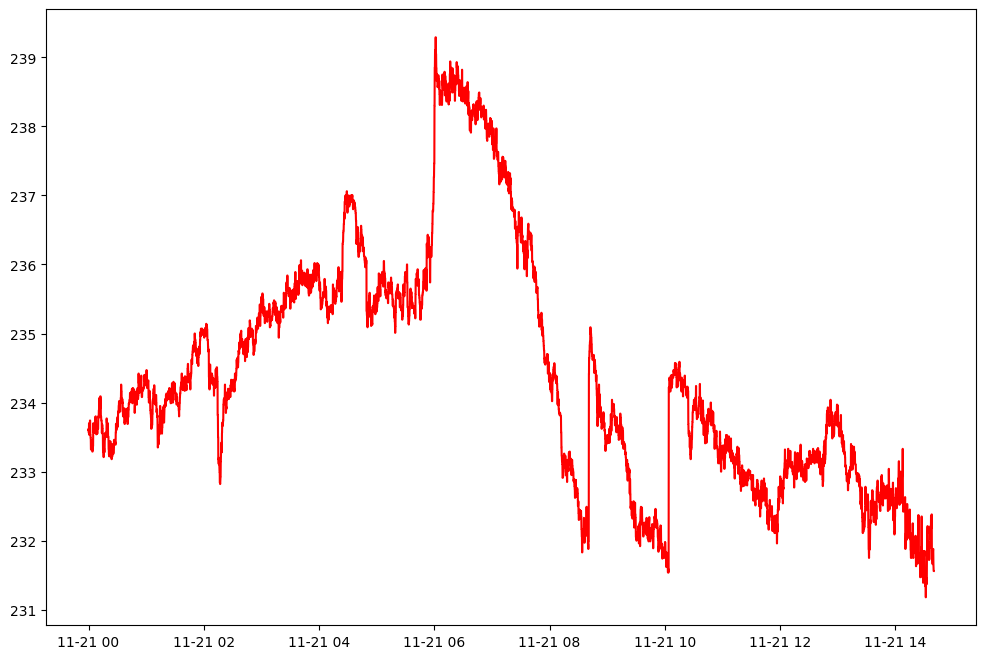

In [16]:
voir = r16_tab1.loc[(r16_tab1['depart']== 1 ) & (r16_tab1['type_mesure']=='tension_n') & (r16_tab1['phase']== 1 )]

x = voir.index
y = voir.prediction
z = voir.mesure

plt.figure(figsize=(12,8))
#plt.plot(x,y, c='blue')
plt.plot(x,z, c='red')